# Animal pose dataset preparation for ControlNet training with OpenPifPaf and Hugging Face

_By: MediaPipe team (Google), Diffusers team (Hugging Face), John Fozard (jfozard), Fiacre Rougieux (fi4cr)

This notebook provides an end-to-end example of preparing a dataset that is compatible with [ControlNet training](https://github.com/huggingface/diffusers/tree/main/examples/controlnet) using OpenPifPaf and Hugging Face. Specifically, in this notebook, we

* Load animals from [Laion5B](https://laion.ai/blog/laion-5b/) using caption base filtering.
* Prepare conditioning images from the original images of the dataset using [OpenPifPaf](https://github.com/openpifpaf/openpifpaf) which has an [animal pose model](https://openpifpaf.github.io/plugins_animalpose.html)
* Prepare the final dataset using [🤗 Datasets](https://huggingface.co/docs/datasets) and push it to the Hugging Face Hub. 

Let's get started!

## Install libraries

In [1]:
!pip install -q datasets transformers accelerate openpifpaf matplotlib opencv-python-headless tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.3/202.3 kB 15.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 2

In [2]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import tensorflow as tf
## Need to stop tf allocating all of the GPU memory - probably shouldn't mix pt and tf like this.
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [10]:
IMG_SIZE = 512

def crop_center(image):
    print(image.shape)
    h, w = image.shape[-3], image.shape[-2]
    if h > w:
        cropped_image = tf.image.crop_to_bounding_box(image, (h - w) // 2, 0, w, w)
    else:
        cropped_image = tf.image.crop_to_bounding_box(image, 0, (w - h) // 2, h, h)
    return tf.image.resize_images(cropped_image, (IMG_SIZE, IMG_SIZE))

def preprocess_image(example):
    # extract the image and label from the example
    image = example['image']
    label = example["objects"]['label']
    
    shape = tf.shape(image)
    height = shape[0]
    width = shape[1]
    
    crop_size = tf.minimum(height, width)
    crop_offset_height = (height - crop_size) // 2
    crop_offset_width = (width - crop_size) // 2
    image = tf.image.crop_to_bounding_box(image, crop_offset_height, crop_offset_width, crop_size, crop_size)

    # resize the image to the desired size
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    

    # normalize the image
    image = tf.cast(image, tf.uint8)

    return {'image': image, 'label': label}

In [11]:
import openpifpaf
openpifpaf.show.Canvas.show = True
openpifpaf.show.Canvas.image_min_dpi = 100
predictor = openpifpaf.Predictor(checkpoint='shufflenetv2k30-animalpose')
predictor.long_edge = 512
predictor.preprocess = predictor._preprocess_factory()

In [12]:
meta = openpifpaf.plugins.animalpose.animal_kp.AnimalKp().head_metas[0]

The connections listed in the OpenPifaf metadata are for a 1-based array
 but in python we prefer zero-based, so subtract 1 from them

In [13]:
zero_based_skeleton = [ (a-1, b-1) for a,b in meta.draw_skeleton]

In [14]:
# Adapted MediaPipe Pose annotation for ControlNet.
# There are fewer keypoints (20) and different connections
# for animals compared to humans

from typing import Any
import numpy as np
import math
import cv2

# Body joint color map. #BGR
_JOINT_CMAP = {
    0: [0, 0, 255],
    1: [255, 208, 0],
    2: [255, 161, 0],
    3: [255, 114, 0],
    4: [0, 189, 255],
    5: [0, 236, 255],
    6: [0, 255, 226],
    7: [255, 0, 76],
    8: [0, 255, 131],
    9: [255, 0, 171],
    10: [0, 255, 37],
    11: [244, 0, 253],
    12: [57, 255, 0],
    13: [151, 0, 255],
    14: [151, 255, 0],
    15: [57, 0, 255],
    16: [245, 255, 0],
    17: [0, 39, 255],
    18: [255, 169, 0],
    19: [0, 133, 255],
}


# Connection color map. #BGR
# These colors probably matter a little, and it's not clear
# exactly how to choose them
# For instance - should they be similar to the keypoint colours or not?
# I've just taken them from the example notebook

_CONNECTION_CMAP = {
 (0, 1): [127, 104, 127],
 (0, 2): [0, 94, 255],
 (0, 5): [255, 184, 0],
 (1, 3): [255, 137, 0],
 (2, 4): [255, 57, 38],
 (1, 2): [0, 212, 255],
 (5, 7): [0, 245, 240],
 (5, 8): [0, 255, 178],
 (5, 9): [127, 127, 104],
 (6, 7): [150, 127, 126],
 (6, 10): [197, 0, 254],
 (6, 11): [122, 127, 221],
 (9, 13): [104, 255, 0],
 (13, 17): [156, 127, 56],
 (8, 12): [104, 0, 255],
 (12, 16): [198, 255, 0],
 (11, 15): [28, 19, 255],
 (15, 19): [28, 66, 255],
 (10, 14): [28, 114, 255],
 (14, 18): [250, 212, 0],
}

# The connections liste


In [15]:
def draw_pose(
    image: np.ndarray,
    landmark_list: Any,
    connections: Any,
    overlay: bool = True,
) -> tuple[np.ndarray, dict[str, list[float]]]:
    """Draws the landmarks and the connections on the image.

    Args:
      image: A three channel BGR image represented as numpy ndarray.
      landmark_list: A normalized landmark list proto message to be annotated on
        the image.
      connections: A list of landmark index tuples that specifies how landmarks to
        be connected in the drawing.
      overlay: Whether to overlay on the input image.

    Returns:
      (image, dictionary).

    Raises:
      ValueError: If one of the following:
        a) If the input image is not three channel BGR.
        b) If any connetions contain invalid landmark index.
    """
    if image.shape[2] != 3:
        raise ValueError("Input image must contain three channel bgr data.")
    image_rows, image_cols, _ = image.shape
    min_length = min(image_rows, image_cols)
    draw_line_width = math.floor(min_length * 0.01)
    draw_circle_radius = math.floor(min_length * 0.015)
    idx_to_coordinates = {}
    
    for idx, landmark in enumerate(landmark_list):
        if landmark[2]>0.0:
            idx_to_coordinates[idx] = (int(landmark[0]), int(landmark[1]))
            
    if overlay:
        output_image = image.copy()
    else:
        output_image = np.zeros(
            list(image.shape[:2])
            + [
                3,
            ],
            dtype=np.uint8,
        )

    if connections:
        num_landmarks = len(landmark_list)
        # Draws the connections if the start and end landmarks are both visible.
        for connection in connections:
            start_idx = connection[0]
            end_idx = connection[1]
            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(
                    "Landmark index is out of range. Invalid connection "
                    f"from landmark #{start_idx} to landmark #{end_idx}."
                )
            if start_idx in idx_to_coordinates and end_idx in idx_to_coordinates:
                cv2.line(
                    output_image,
                    pt1=idx_to_coordinates[start_idx],
                    pt2=idx_to_coordinates[end_idx],
                    color=_CONNECTION_CMAP[(start_idx, end_idx)],
                    thickness=draw_line_width,
                )

    # Draws landmark points after finishing the connection lines, which is
    # aesthetically better.
    for idx, landmark_px in idx_to_coordinates.items():
        # Fill color into the circle
        cv2.circle(
            output_image,
            center=landmark_px,
            radius=draw_circle_radius,
            color=_JOINT_CMAP[idx],
            thickness=-1,
        )

    return output_image

In [16]:
import torch
torch.cuda.empty_cache()

def determine_pose(image):
    """Estimates pose and creates an image with just the pose body points.

    The image consisting the pose body points serves as the conditioning image
    for ControlNet training.

    Args:
        image: A three channel RGB image represented as a tf.Tensor.

    Returns:
        A tuple consisting of the original image (`image`), an image where
        the original image is overlaid with the pose keypoints, and an image
        with just the pose keypoints.
    """
    image = np.asarray(image)
    
    predictions, gt_anns, image_meta = predictor.numpy_image(image)
    if not predictions:
        data = np.zeros((20,3))
    else:
        data = predictions[0].data

    # Draw pose landmarks on a copy of the input image.
    annotated_image = draw_pose(
        image, data, zero_based_skeleton
    )

        # Draw pose landmarks on a blank image.
    blank_image = draw_pose(
        image, data, zero_based_skeleton, False
    )

    return image, annotated_image, blank_image

In [17]:
import requests
from PIL import Image
from io import BytesIO
import json
import matplotlib.pyplot as plt

with open('urls.json', 'r') as f:
    my_dict = json.load(f)

first_key, first_value = next(iter(my_dict.items()))
response = requests.get(first_value)
img = Image.open(BytesIO(response.content))

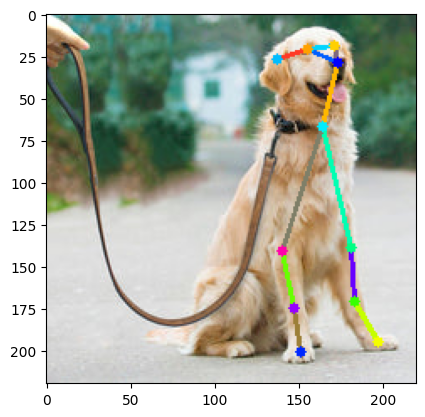

In [18]:
# Test determine_pose on a single image
output_image, annotated_image, black_image = determine_pose(img)
plt.imshow(annotated_image)

## Visualize

Issues making that request


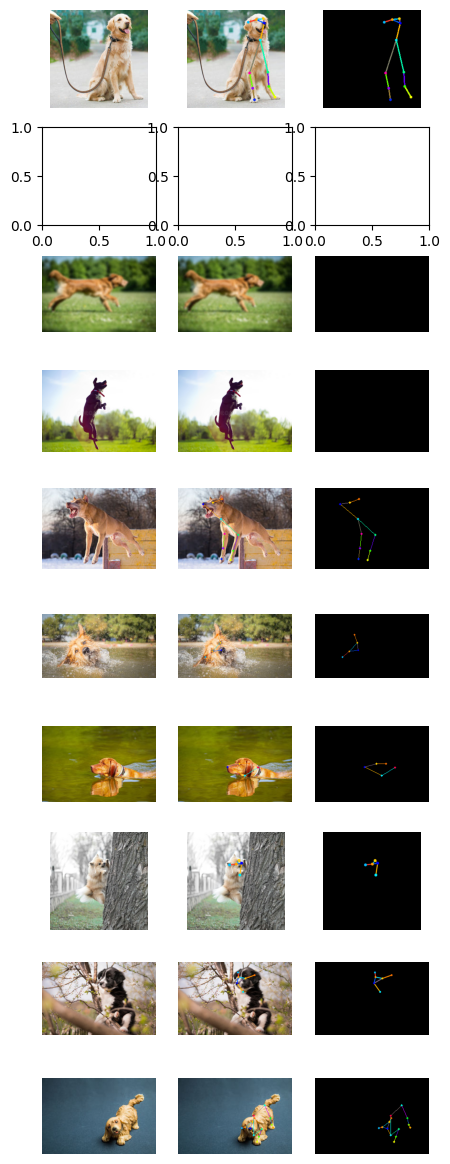

In [19]:
num_samples_to_vis = 10
captions_list = list(my_dict.keys())
urls_list = list(my_dict.values())
fig, ax = plt.subplots(ncols=3, nrows=num_samples_to_vis, figsize=(5, 15))
for i in np.arange(num_samples_to_vis):
    
    try:
        response = requests.get(urls_list[i])
        img = Image.open(BytesIO(response.content))
        sample = determine_pose(img)
        original_image = sample[0]
        annotated_image, blank_image = sample[1], sample[2]

        
        
        samples = [original_image, annotated_image, blank_image]
        titles = ["Input", "Annotation Overlaid", "Annotation"]

        for j in range(3):
            ax[i, j].imshow(samples[j])
            ax[i, j].axis("off")
    except:
          print("Issues making that request")

In [20]:
import os
import hashlib
import PIL

## Serialize dataset

In this section, we serialize the original images, their corresponding conditioning images, and generate BLIP captions.

In [44]:
import tqdm

batch_size = 1
data_root = "data"
#new_dataset = dataset.batch(batch_size, drop_remainder=True)

os.makedirs(data_root, exist_ok=True)


def save_image(
    original_image: np.ndarray,
    overlaid_annotation: np.ndarray,
    blank_annotation: np.ndarray,
):
    """Serializes images to `data_root`."""
    image_hash = hashlib.sha1(original_image.tobytes()).hexdigest()
    PIL.Image.fromarray(original_image).save(
        os.path.join(data_root, f"{str(image_hash)}_original.png")
    )
    PIL.Image.fromarray(overlaid_annotation).save(
        os.path.join(data_root, f"{str(image_hash)}_overlaid.png")
    )
    PIL.Image.fromarray(blank_annotation).save(
        os.path.join(data_root, f"{str(image_hash)}_condition.png")
    )
    return image_hash


original_image_paths = []
overlaid_annotation_paths = []
blank_annotation_paths = []
all_generated_captions = []
total = 0

for i in np.arange(len(urls_list)):
    
    try:
        generated_captions = captions_list[i]
        response = requests.get(urls_list[i])
        img = Image.open(BytesIO(response.content))
        samples = determine_pose(img)
        original_images = samples[0]
        overlaid_annotations = samples[1]
        blank_annotations = samples[2]

        generated_captions = captions_list[i]


        image_hash = save_image(
            original_images, overlaid_annotations, blank_annotations
        )
        original_image_paths.append(
            os.path.join(data_root, f"{str(image_hash)}_original.png")
        )
        overlaid_annotation_paths.append(
            os.path.join(data_root, f"{str(image_hash)}_overlaid.png")
        )
        blank_annotation_paths.append(
            os.path.join(data_root, f"{str(image_hash)}_condition.png")
        )

        all_generated_captions.append(generated_captions)

        total += 1
        print(str(i/len(urls_list)*100)+"%")
    except:
        print("Issue")

print(f"{total} samples will go in the final dataset.")

0.0%


Issue
0.30959752321981426%
0.46439628482972134%
0.6191950464396285%
0.7739938080495357%
0.9287925696594427%
1.08359133126935%
1.238390092879257%
1.393188854489164%
1.5479876160990713%
1.7027863777089782%
1.8575851393188854%
Issue
2.1671826625387%
2.321981424148607%
2.476780185758514%
2.631578947368421%
2.786377708978328%
2.941176470588235%
3.0959752321981426%
3.2507739938080498%
3.4055727554179565%
3.560371517027864%
3.7151702786377707%
3.8699690402476783%
Issue
4.179566563467492%
4.3343653250774%
4.489164086687306%
4.643962848297214%
4.798761609907121%
4.953560371517028%
5.108359133126935%
5.263157894736842%
Issue
Issue
Issue
5.88235294117647%
6.037151702786378%
6.191950464396285%
Issue
6.5015479876160995%
6.656346749226007%
6.811145510835913%
6.96594427244582%
7.120743034055728%
7.275541795665634%
7.430340557275541%
7.5851393188854495%
7.739938080495357%
7.894736842105263%
8.04953560371517%
8.204334365325078%
Issue
8.513931888544892%
8.6687306501548%
8.823529411764707%
8.978328173374

Issue
Issue
73.52941176470588%
73.68421052631578%
73.83900928792569%
73.9938080495356%
74.14860681114551%
74.30340557275542%
74.45820433436533%
74.61300309597523%
74.76780185758514%
74.92260061919505%
75.07739938080495%
75.23219814241486%
75.38699690402477%
75.54179566563467%
75.69659442724458%
75.85139318885449%
76.0061919504644%
76.16099071207431%
Issue
76.47058823529412%
76.62538699690403%
76.78018575851394%
76.93498452012383%
77.08978328173374%
77.24458204334366%
77.39938080495357%
Issue
77.70897832817337%
77.86377708978328%
78.0185758513932%
78.1733746130031%
Issue
78.48297213622291%
78.63777089783281%
78.79256965944272%
78.94736842105263%
79.10216718266254%
79.25696594427245%
79.41176470588235%
79.56656346749226%
79.72136222910217%
79.87616099071208%
80.03095975232199%
80.18575851393189%
80.34055727554178%
80.4953560371517%
80.6501547987616%
Issue
80.95975232198143%
81.11455108359134%
81.26934984520123%
81.42414860681114%
81.57894736842105%
81.73374613003097%
81.88854489164086%
I

## Create a 🤗 Dataset and push to the Hub

For this section, we leverage 🤗 Datasets to create a the final dataset that is ready to go with our [ControlNet training script](https://github.com/huggingface/diffusers/blob/main/examples/controlnet/train_controlnet_flax.py). 

Finally, we push the prepared dataset to Hub for easy sharing with the community. To be able to do that, you need to be a registered Hugging Face user to authenticate yourself. If you are not one already, please head over [hf.co](https://hf.co) and register youself; it's free =) 

In [39]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) 
Token is valid.
Cannot authenticate through git-credential as no helpe

We start with a generator that yields a tuple consisting of:

* `original_image`
* `condtioning_image`
* `overlaid`
* `caption`

Note that `overlaid` image is just there for convenience. It is not **mandatory** for us to include it while creating the dataset as it won't be used during training. 

In [45]:
!pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
from imageio import imread

def gen_examples():
    for i in range(len(original_image_paths)):
        im = imread(blank_annotation_paths[i])
        if not im.sum():
            continue
        else:
            yield {
                "original_image": {"path": original_image_paths[i]},
                "conditioning_image": {"path": blank_annotation_paths[i]},
                "overlaid": {"path": overlaid_annotation_paths[i]},
                "caption": all_generated_captions[i],
            }

In [47]:
from datasets import Dataset, Features
from datasets import Image as ImageFeature
from datasets import Value

final_dataset = Dataset.from_generator(
    gen_examples,
    features=Features(
        original_image=ImageFeature(),
        conditioning_image=ImageFeature(),
        overlaid=ImageFeature(),
        caption=Value("string"),
    ),
    num_proc=6,
)

ds_name = "small-animal-poses-controlnet-dataset"
final_dataset.push_to_hub(ds_name)

Generating train split: 0 examples [00:00, ? examples/s]

<ipython-input-46-dab75e6ff45d>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imread(blank_annotation_paths[i])


Dataset generator downloaded and prepared to /root/.cache/huggingface/datasets/generator/default-86d805f68e1167c7/0.0.0. Subsequent calls will reuse this data.


Map:   0%|          | 0/206 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

In [48]:
len(original_image_paths), len(blank_annotation_paths), len(overlaid_annotation_paths), len(all_generated_captions)

(577, 577, 577, 577)

Refer to [`from_generator()` documentation](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.from_generator) to know more about it. 

Note that, you can specify `private=True` in `push_to_hub` to host the dataset privately. 

